In [690]:
#!conda install -c conda-forge python-docx seaborn

In [691]:
%load_ext autoreload
%aimport model
%autoreload 2
import pickle
from pathlib import Path

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [692]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display

In [693]:
# redondant dans prepross_power
def year_month_date_to_string(date):
    return date.strftime('%Y%m')

def datetime_attributes(df, column, attribute=['year', 'month', 'day', 'hour', 'dayofyear', 'quarter']):
    # define generator expression of series, one for each attribute
    date_gen = (getattr(df[column].dt, i).rename(i) for i in attribute)
    return pd.concat(date_gen, axis=1)

def datetime_isocalendar(df, column, attribute=['year','week', 'weekday']):
    date_gen =  df.apply(lambda x: x[column].isocalendar(), axis=1, result_type='expand')
    date_gen = date_gen.rename(columns= dict((i,j) for i,j in enumerate(attribute)))
    date_gen['is_workday'] = date_gen['weekday'].apply(lambda  x: 1 if x<6 else 0)
    #date_gen['workday'] =  1 if date_gen['weekday']<6 else 0
    print(date_gen.head())
    return date_gen

In [694]:
sns.set_style("whitegrid")
figure_size =[20,6]
save_dir = 'media'

In [695]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
invalid = '<>:"/\|?* '

In [696]:
filename = "ConsommationUniversite.pickle"
df = pd.read_pickle(filename)
print(df.shape)
year = df['year'].unique()
print(year)
print(df.columns)
print(max(df['Power [kW]']),max(df['Power Clipped [kW]']))

(69504, 16)
[2015 2016]
Index(['Timestamp', 'Power [kW]', 't', 'year', 'month', 'day', 'hour', 'dayofyear', 'quarter', 'week', 'weekday', 'is_workday', 'year_month', 'month_week', 'Power Clipped [kW]', 'is_peak'], dtype='object')
12442.0 2442.0


In [697]:
def generate_Si(dataf, start, stop,name):
    d = pd.DataFrame(index=dataf.index)
    for i, (b, e) in enumerate(zip(start,stop)):
        ts = dataf.between_time(b, e)
        n = name+str(i+1)
        #try:
        d.loc[dataf.index,n] = 0

        #except:
        #    pass
        d.loc[ts.index,n] = np.where((ts['is_workday'] ==1), 1, 0)
    return d.copy(True)

In [698]:
df['time'] = df.index

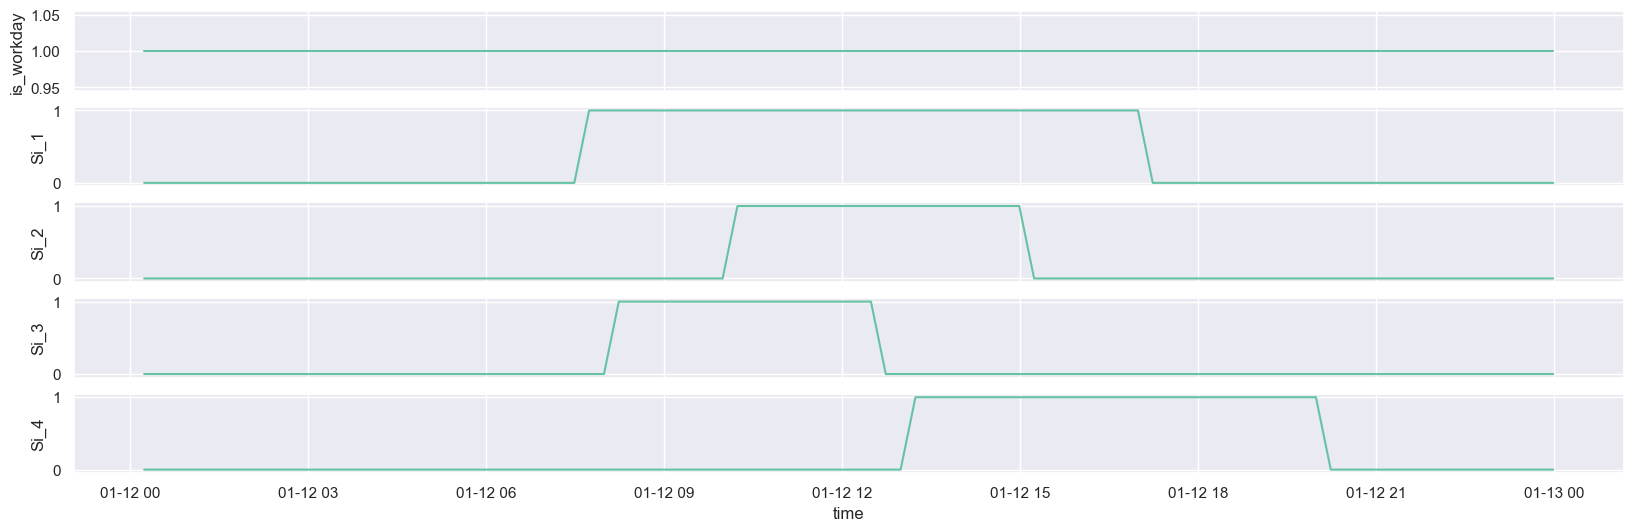

In [699]:
en = df[(df['dayofyear'] == 12) & (df['year'] == 2015)]

sig = generate_Si(df,
                 start=['07:30', '10:00', '08:00', '13:00'],
                 stop=['17:00', '15:00', '12:30', '20:00'],name='Si_')

en = pd.concat([en, sig], axis=1)

title = "Connections lors d'une journée"
what= 'time'

sns.set_theme(style="darkgrid",palette='Set2')

fig, axs = plt.subplots(nrows=5, figsize=figure_size, sharex=True)
g = sns.lineplot(x=what, y='is_workday', estimator='max', data=en,  ax=axs[0])
g = sns.lineplot(x=what, y='Si_1', estimator='max', data=en, ax=axs[1])
g = sns.lineplot(x=what, y='Si_2', estimator='max', data=en, ax=axs[2])
g = sns.lineplot(x=what, y='Si_3', estimator='max', data=en, ax=axs[3])
g = sns.lineplot(x=what, y='Si_4', estimator='max', data=en, ax=axs[4])
for char in invalid:
	filename = title.replace(char, '_')+'.png'
filename = Path(save_dir,filename)
plt.show()
fig.savefig(filename, format='png', dpi=100, bbox_inches='tight')


for char in invalid:
	filename = title.replace(char, '_')+'.png'
filename = Path(save_dir,filename)

axs[0].title.set_text(title)
plt.show()
fig.savefig(filename, format='png', dpi=100, bbox_inches='tight')


                     Si_1  Si_2  Si_3  Si_4
index                                      
2015-01-08 00:14:00   0.0   0.0   0.0   0.0
2015-01-08 00:29:00   0.0   0.0   0.0   0.0
2015-01-08 00:44:00   0.0   0.0   0.0   0.0
2015-01-08 00:59:00   0.0   0.0   0.0   0.0
2015-01-08 01:14:00   0.0   0.0   0.0   0.0


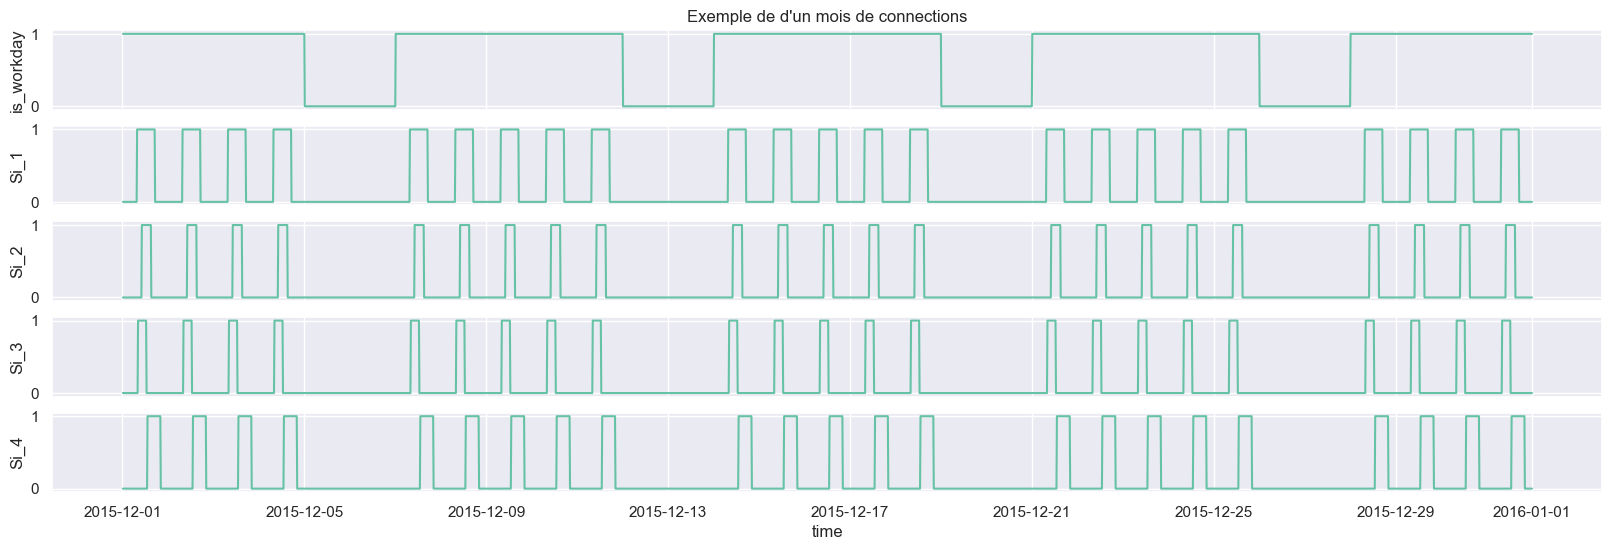

In [700]:
en = df[(df['month'] == 12) & (df['year'] == 2015)]

sig = generate_Si(df,
                 start=['07:30', '10:00', '08:00', '13:00'],
                 stop=['17:00', '15:00', '12:30', '20:00'],name='Si_')

print(sig.head())

en = pd.concat([en, sig], axis=1)

title = "Exemple de d'un mois de connections"
what= 'time'

sns.set_theme(style="darkgrid",palette='Set2')

fig, axs = plt.subplots(nrows=5, figsize=figure_size, sharex=True)
g = sns.lineplot(x=what, y='is_workday', estimator='max', data=en,  ax=axs[0])
g = sns.lineplot(x=what, y='Si_1', estimator='max', data=en, ax=axs[1])
g = sns.lineplot(x=what, y='Si_2', estimator='max', data=en, ax=axs[2])
g = sns.lineplot(x=what, y='Si_3', estimator='max', data=en, ax=axs[3])
g = sns.lineplot(x=what, y='Si_4', estimator='max', data=en, ax=axs[4])

for char in invalid:
	filename = title.replace(char, '_')+'.png'
filename = Path(save_dir,filename)

axs[0].title.set_text(title)
plt.show()
fig.savefig(filename, format='png', dpi=100, bbox_inches='tight')


# LE DEBUT DU CHANGEMENT

In [701]:
period_begin = '2015-01-12'
period_end = '2015-12-14'
#an = df[df['year'] == year[0]]

Si_gen = generate_Si(df,
                 start=['07:30', '10:00', '08:00', '13:00'],
                 stop=['17:00', '15:00', '12:30', '20:30'],name='Si_')
# Si_gen = generate_Si(df,
#                  start=['08:00','08:00','08:00','08:00' ],
#                  stop=['20:00','20:00','20:00','20:00'],name='Si_')
#print(Si_gen)

an = pd.concat([df, Si_gen], axis=1)
#an = an[(an['week'] == 3) & (an['year'] == 2015)]


#POWER_FOR_Pb = 'Power [kW]'
POWER_FOR_Pb = 'Power Clipped [kW]'
Pb = an[POWER_FOR_Pb].loc[period_begin:period_end]
idx = Pb.index
Pb = Pb.to_numpy(copy=True)
Si = Si_gen.loc[period_begin:period_end]
Si = Si.astype(float).to_numpy(copy=True)

Si_tot = np.amax(Si, axis=1)

#df2 = an.loc[period_begin:period_end]
#df2 = an
print(Pb.shape, Si.shape, Si_tot.shape)

l = Pb.shape[0]
print("maximum de Pb(t) :{m} avec T={t}".format(m=max(Pb), t=l))

arrivee = []
depart = []
for sign in Si.T:
    # JUMP
    thres = 0.5
    si = sign
    y = np.where(np.logical_and(si>-thres,si<thres), 0, 1) # ACTIVITY

    der_y = np.diff(y)
    higherPeaks = np.where(der_y>=1)[0]
    lowerPeaks = np.where(der_y<=-1)[0]
    arrivee.append(higherPeaks)
    depart.append(lowerPeaks)
    # plt.figure()
    # plt.plot(si)
    # plt.plot(higherPeaks, si[higherPeaks], 'ro')
    # plt.plot(lowerPeaks, si[lowerPeaks], 'ko')

(32352,) (32352, 4) (32352,)
maximum de Pb(t) :2442.0 avec T=32352


In [702]:
df_grp_ym = an.loc[period_begin:period_end].groupby(by='year_month').agg({'Power Clipped [kW]':'max', 'Power [kW]':'max','year':'max','month':'max','day':['nunique','idxmin','idxmax']
                                              ,'t':['min','max']
                                                   }).reset_index('year_month')
df_grp_ym.columns = df_grp_ym.columns.to_flat_index()
display(df_grp_ym)
Pb_max__m = df_grp_ym[POWER_FOR_Pb,'max'].to_numpy(copy=True)

t_min__m = df_grp_ym['t','min'].to_numpy(copy=True)
t_max__m = df_grp_ym['t','max'].to_numpy(copy=True)
print(Pb_max__m)
print(t_min__m)
print(t_max__m)

,"(year_month, )","(Power Clipped [kW], max)","(Power [kW], max)","(year, max)","(month, max)","(day, nunique)","(day, idxmin)","(day, idxmax)","(t, min)","(t, max)"
0,201501,1334.0,11334.0,2015,1,20,2015-01-12 00:14:00,2015-01-31 00:14:00,384,2303
1,201502,1690.0,11690.0,2015,2,28,2015-02-01 00:14:00,2015-02-28 00:14:00,2304,4991
2,201503,958.0,10958.0,2015,3,31,2015-03-01 00:14:00,2015-03-31 00:14:00,4992,7967
3,201504,0.0,9954.0,2015,4,30,2015-04-01 00:14:00,2015-04-30 00:14:00,7968,10847
4,201505,786.0,10786.0,2015,5,31,2015-05-01 00:14:00,2015-05-31 00:14:00,10848,13823
5,201506,1048.0,11048.0,2015,6,30,2015-06-01 00:14:00,2015-06-30 00:14:00,13824,16703
6,201507,2168.0,12168.0,2015,7,31,2015-07-01 00:14:00,2015-07-31 00:14:00,16704,19679
7,201508,830.0,10830.0,2015,8,31,2015-08-01 00:14:00,2015-08-31 00:14:00,19680,22655
8,201509,2442.0,12442.0,2015,9,30,2015-09-01 00:14:00,2015-09-30 00:14:00,22656,25535
9,201510,0.0,9906.0,2015,10,31,2015-10-01 00:14:00,2015-10-31 00:14:00,25536,28511


[1334. 1690.  958.    0.  786. 1048. 2168.  830. 2442.    0.  542.  476.]
[  384  2304  4992  7968 10848 13824 16704 19680 22656 25536 28512 31392]
[ 2303  4991  7967 10847 13823 16703 19679 22655 25535 28511 31391 32735]


In [703]:
print('Set problem parameters')
n_ev = 1600.0
#n_ev = 1.0
# Prius 4.4kWh, Leaf 24kWh
soc_max = 48#0.8*24*n_ev
soc_min = 9#0.2*4.4*n_ev
print("{mi} <= SOC <= {ma}".format(mi=soc_min, ma=soc_max))

bn = 0.2*n_ev
#bn = 40
params = {
    # Variables	Descriptions	Unités
    'C__E': 0.003830,
    'C__P': 14.677,
    'C__b_n': np.tile(np.array([[0.0196], [0.268]]),4) ,#np.ones(shape=(2, 4)), #[0.0196, 0.268], #np.ones(shape=(2, 4)) # [[1.0, 1.0, 1.0, 1.0],[1.0, 1.0, 1.0, 1.0]]

    'SOCmin': soc_min,  # État de charge minimum des véhicules électriques	kWh
    'SOCmax': soc_max,  # État de charge maximum des véhicules électriques	kWh
    'Pch_min': (4.4*(15/60)),  # Puissance de charge minimum 	kW
    'Pdis_min': (4.4*(15/60)),  # Puissance de décharge minimum	kW
    'Pch_max_n': [10, 63], #[bn*7.5, bn*50.0],  # Puissance de charge maximum en utilisant les bornes de type n	kW
    'Pdis_max_n': [10, 63], #[bn*5.0, bn*40.0],  # Puissance de décharge maximum en utilisant les bornes de type n	kW
    'beta_ch': 0.93,  # Efficacité de charge	%
    'beta_dis': 0.93,  # Efficacité de décharge	%
    'NEVs': n_ev,  # Nombre de véhicules électriques	Qté
    'Rut': [0.42, 0.01, 0.19, 0.38],  # Ratio d’utilisateurs avec le profil i	%
    #'Rut': [1.0, 1.0, 1.0, 1.0],  # Ratio d’utilisateurs avec le profil i	%
    'delta_t': 15 / 60,  # 15mins
    'MAX_OPTIM': 1e7,  # Facteur majorant du programme d'optimisation

    'Pb': Pb,  # Puissance appelée par le bâtiment appelée à l’instant t	kW
    'Pb_max__m': Pb_max__m,
    'Si': Si, #1, Si le profil d’utilisateur est raccordé à une borne à l’instant t

    't_min__m': t_min__m,
    't_max__m': t_max__m,

    'arrivee':arrivee,
    'depart':depart,
}

Set problem parameters
9 <= SOC <= 48


In [704]:
#%aimport model
#more: https://ibmdecisionoptimization.github.io/docplex-doc/mp/docplex.mp.solution.html#docplex.mp.solution.SolveSolution
mdl = model.ModelShaving('V2B', params=params)
mdl.problem_variables()
mdl.problem_constraints() # Contraintes de base sut SOC, Pch, Pdis, delta selon n,i,t
mdl.cout_energie = mdl.problem_cout_energie()
mdl.cout_puissance = mdl.problem_cout_puissance()
mdl.cout_infrastructure = mdl.problem_cout_infrastructure()
f_objective = mdl.cout_energie+mdl.cout_puissance#+mdl.cout_infrastructure
mdl.minimize(f_objective)
# TODO: mettre les problem_cout_... en vecteurs/retirer la dernière somme pour avoir min et max
mdl.add_kpi(mdl.cout_energie, "Cout Energie ($)")
mdl.add_kpi(mdl.cout_puissance, "Cout Puissance ($)")
mdl.add_kpi(mdl.cout_infrastructure, "Cout infrastructure ($)")
mdl.add_kpi(mdl.max(mdl.params['Pb_max__m']), "max Puissance Pb_max[m] clipped (kW)")
mdl.add_kpi(mdl.max(mdl.Pr__t), "max Puissance Preseau clipped (kW)")



mdl.problem_constraint_SOC__n_i_t_arrivee_depart()
#mdl.problem_constraint_uc_connexion_deconnection() # actuellement non utilisé (remplacé par arrivee , depart )

mdl.ctr_Pr__t = mdl.problem_constraint_Pr__t()
mdl.problem_constraint_SOC__n_i_t() # Bloque les autres, mais sans delta delta_ch/dis__n_i_t
mdl.problem_constraint_Pch_total__t()
mdl.problem_constraint_Pdis_total__t()
mdl.problem_constraint_Pr_t__max__m()

mdl.problem_constraint_prevent_simultaneous_charge_and_discharge_i_t()

#mdl.problem_constraint_Pr__n_i_t()

# ceci est nouveau
#mdl.problem_constraint_uc_soc_ramp_up_and_soc_ramp_down() # autre façon pour le SOC mais sans ch & desch
#mdl.problem_constraint_SOC__n_i_t_latch_on() # Le faire pour charge/discharge ?!

print('\n')
mdl.print_information()
solus = mdl.solve()
assert solus, "!!! Solve of the model fails"
print("********************************************")
print("Obj", mdl.solution.get_objective_value())
#mdl.print_solution(print_zeros=False)
print("--------------------------------------------")
mdl.report()
print("--------------------------------------------")
print('end')
with open('solution.pickle', mode='wb') as f:
    pickle.dump(solus, f)
filename = Path(save_dir,'solution.json')
with open('solution.json', mode='wb') as f:
    solus.export(f,format='json')

{'utilsateur': 4, 'borne': 2, 'instant': 32352, 'mois': 12, 'I': range(1, 5), 'N': range(1, 3), 'T': range(0, 32352), 'M': range(0, 12)}
[[504   8 152 304]
 [168   8 152 304]]
0 0 1344
1 0 1920
2 0 2688
3 0 2976
4 0 2880
5 0 2976
6 0 2880
7 0 2976
8 0 2976
9 0 2880
10 0 2976
11 0 2880


Model: V2B
 - number of variables: 1649953
   - binary=258816, integer=0, continuous=1391137
 - number of constraints: 1427336
   - linear=1427336
 - parameters: defaults
 - objective: minimize
 - problem type is: MILP
********************************************
Obj 78230.30497002363
--------------------------------------------
* model V2B solved with objective = 78230.305
*  KPI: Cout Energie ($)                     = 31.249
*  KPI: Cout Puissance ($)                   = 78199.056
*  KPI: Cout infrastructure ($)              = 103378.330
*  KPI: max Puissance Pb_max[m] clipped (kW) = 2442.000
*  KPI: max Puissance Preseau clipped (kW)   = 1258.000
--------------------------------------------
end


In [705]:
dk = pd.DataFrame({'Pb batiment': mdl.params['Pb'],
                   'Pr reseau': solus.get_value_list(mdl.Pr__t),
                   'P charge totale': solus.get_value_list(mdl.Pch_tot__t),
                   'P décharge totale': solus.get_value_list(mdl.Pdis_tot__t),
                   'Si': Si_tot,
                   #'t':idx
                   }
                  ).set_index(idx)
#dk.to_csv('resultats.csv')

/var/folders/ml/k9khjmr57qqcw3y03b7k154c0000gn/T/ipykernel_44051/907409636.py:5: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  g = dk.plot(figsize=figure_size,subplots=True, ax=ax, sharex=True)


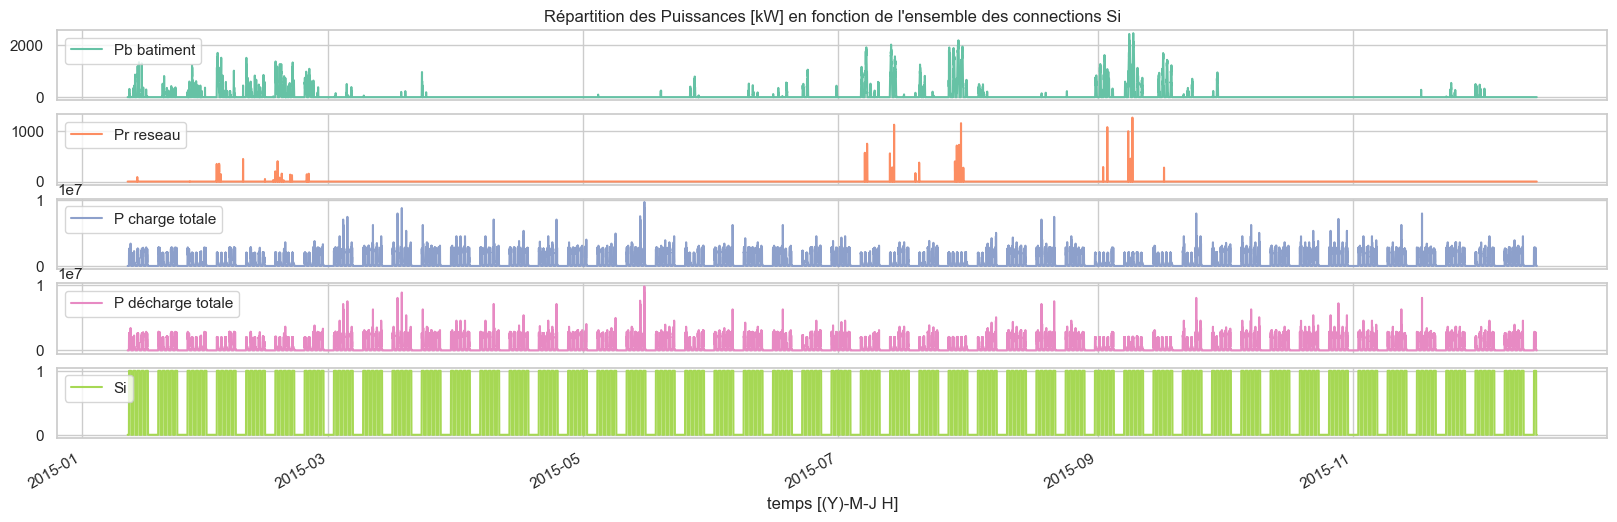

In [706]:
title = "Répartition des Puissances [kW] en fonction de l'ensemble des connections Si"
sns.set_style("whitegrid")
fig, ax = plt.subplots(figsize=figure_size, sharex=True)
fig1 = ax.get_figure()
g = dk.plot(figsize=figure_size,subplots=True, ax=ax, sharex=True)
for i in g:
    i.legend(loc='upper left')
g[0].set_title(title)
g[-1].set_xlabel('temps [(Y)-M-J H]')
#for char in invalid:
#	filename = title.replace(char, '_')+'.png'
filename = Path(save_dir,title+'.png')

plt.show()

fig1.savefig(filename, format='png', dpi=200, bbox_inches='tight')

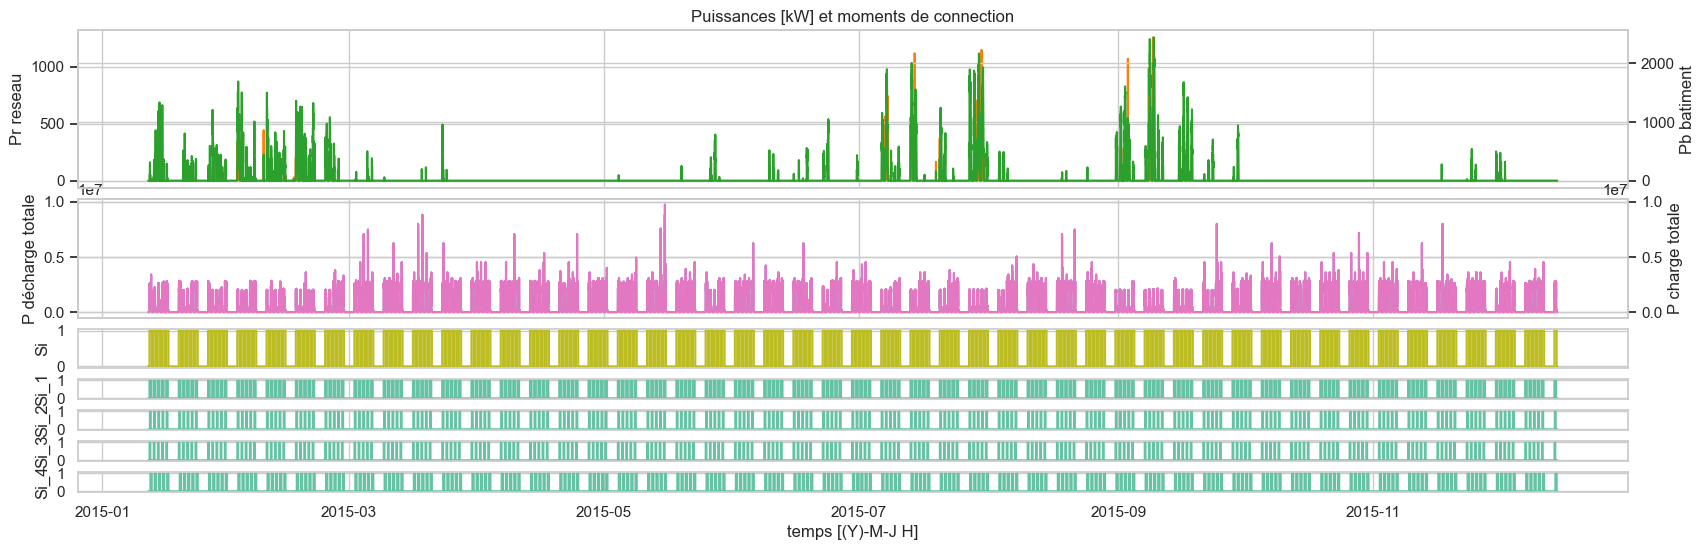

In [707]:
title = 'Puissances [kW] et moments de connection'
en = pd.DataFrame(mdl.params['Si'], columns=['Si_1', 'Si_2','Si_3','Si_4'])
en['t'] = idx
sns.set_style("whitegrid")

fig, axs = plt.subplots(nrows=7, figsize=figure_size, sharex=True,
                        gridspec_kw={'height_ratios': [2.0, 1.5, 0.5, 0.25, 0.25, 0.25, 0.25]})

g = sns.lineplot(x=dk.index, y='Pr reseau', estimator='max', data=dk,  ax=axs[0], color='tab:orange')
ax2 = g.twinx()
h = sns.lineplot(x=dk.index, y='Pb batiment', estimator='max', data=dk, ax=ax2, color='tab:green',dashes=True)
g = sns.lineplot(x=dk.index, y='P décharge totale', estimator='max', data=dk,  ax=axs[1], color='tab:purple', dashes=True)
ax2 = g.twinx()
h = sns.lineplot(x=dk.index, y='P charge totale', estimator='max', data=dk, ax=ax2, color='tab:pink', dashes=True)
#g.set_yticklabels(g.get_yticklabels(), rotation=45)
#h.set_yticklabels(h.get_yticklabels(), rotation=45)

#g.tick_params(axis='y', labelrotation = 45)

what = 't'
g = sns.lineplot(x=dk.index, y='Si', estimator='max', data=dk, ax=axs[2], drawstyle="steps", color="tab:olive")
g = sns.lineplot(x=what, y='Si_1', estimator='max', data=en, ax=axs[3], drawstyle="steps")
g = sns.lineplot(x=what, y='Si_2', estimator='max', data=en, ax=axs[4], drawstyle="steps")
g = sns.lineplot(x=what, y='Si_3', estimator='max', data=en, ax=axs[5], drawstyle="steps")
g = sns.lineplot(x=what, y='Si_4', estimator='max', data=en, ax=axs[6], drawstyle="steps")
axs[6].set_xlabel('temps [(Y)-M-J H]')
for a in range(3, 7):
    axs[a].set_yticks([0, 1])

for char in invalid:
	filename = title.replace(char, '_')+'.png'
filename = Path(save_dir,filename)

axs[0].title.set_text(title)
plt.show()
fig.savefig(filename, format='png', dpi=200, bbox_inches='tight')


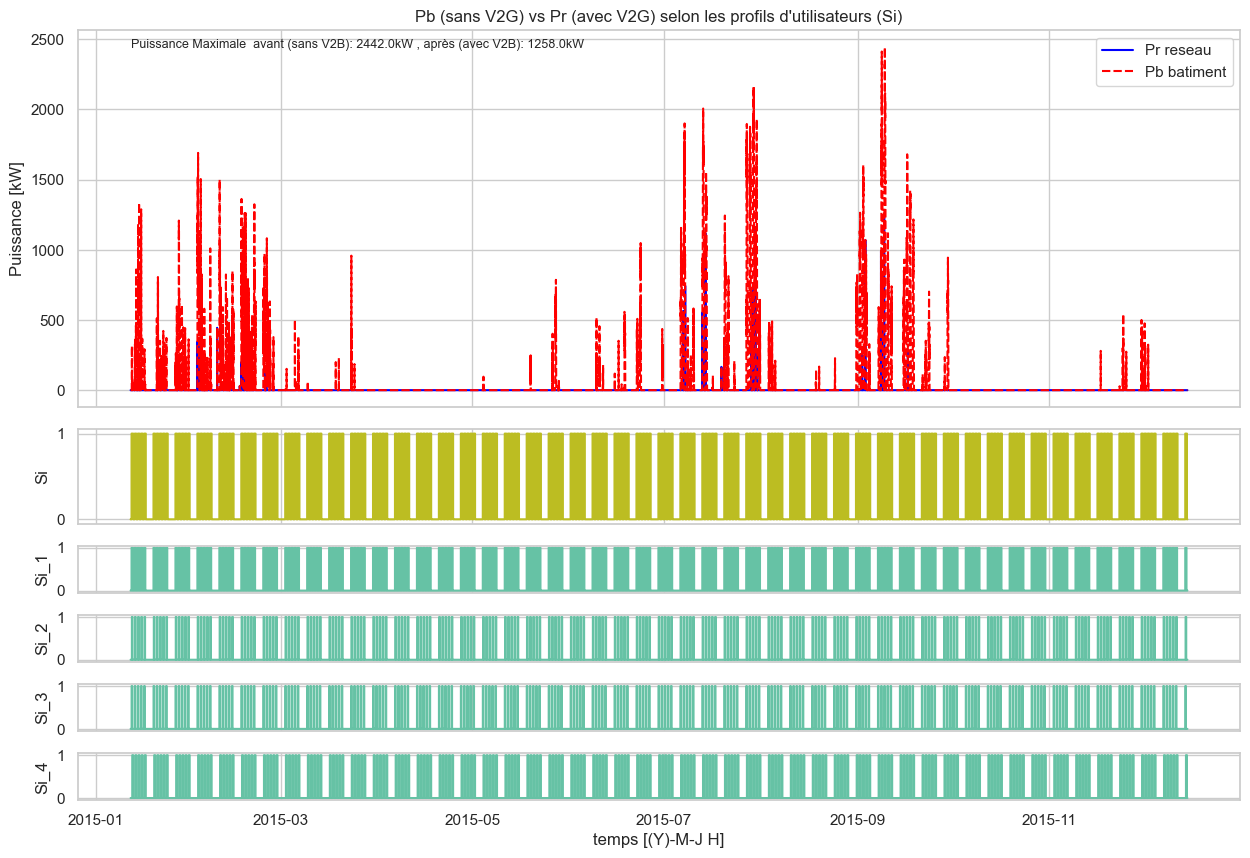

Puissance Maximale  avant (sans V2B): 2442.0kW , après (avec V2B): 1258.0kW 


In [708]:
text = 'Puissance Maximale  avant (sans V2B): {b}kW , après (avec V2B): {r}kW '.format(b=dk['Pb batiment'].max(), r=dk['Pr reseau'].max() )

idb_max = dk['Pb batiment'].idxmax()

title = "Pb (sans V2G) vs Pr (avec V2G) selon les profils d'utilisateurs (Si)"
en = pd.DataFrame(mdl.params['Si'], columns=['Si_1', 'Si_2','Si_3','Si_4'])
en['t'] = idx
sns.set_style("whitegrid")

fig, axs = plt.subplots(nrows=6, ncols=1, figsize=(15,10), sharex=True, gridspec_kw={'height_ratios': [2, 0.5,0.25, 0.25, 0.25, 0.25]})
g = sns.lineplot(data=dk[['Pr reseau','Pb batiment']],  ax=axs[0], palette=['b','r'])
axs[0].text(dk.index[0], dk['Pb batiment'][idb_max], text, fontsize=9)
axs[0].set_ylabel('Puissance [kW]')
g = sns.lineplot(x=dk.index, y='Si', estimator='max', data=dk, ax=axs[1], drawstyle="steps", color='tab:olive')
g = sns.lineplot(x=what, y='Si_1', estimator='max', data=en, ax=axs[2], drawstyle="steps")
g = sns.lineplot(x=what, y='Si_2', estimator='max', data=en, ax=axs[3], drawstyle="steps")
g = sns.lineplot(x=what, y='Si_3', estimator='max', data=en, ax=axs[4], drawstyle="steps")
g = sns.lineplot(x=what, y='Si_4', estimator='max', data=en, ax=axs[5], drawstyle="steps")
axs[5].set_xlabel('temps [(Y)-M-J H]')
for a in range(1,6):
    axs[a].set_yticks([0, 1])
for char in invalid:
	filename = title.replace(char, '_')+'.png'
filename = Path(save_dir,filename)

axs[0].title.set_text(title)
plt.show()
fig.savefig(filename, format='png', dpi=200, bbox_inches='tight')


print(text)

n  i
1  1     5040.0
   2       80.0
   3     1520.0
   4     3040.0
2  1    10584.0
   2      504.0
   3     9576.0
   4    19152.0
dtype: float64


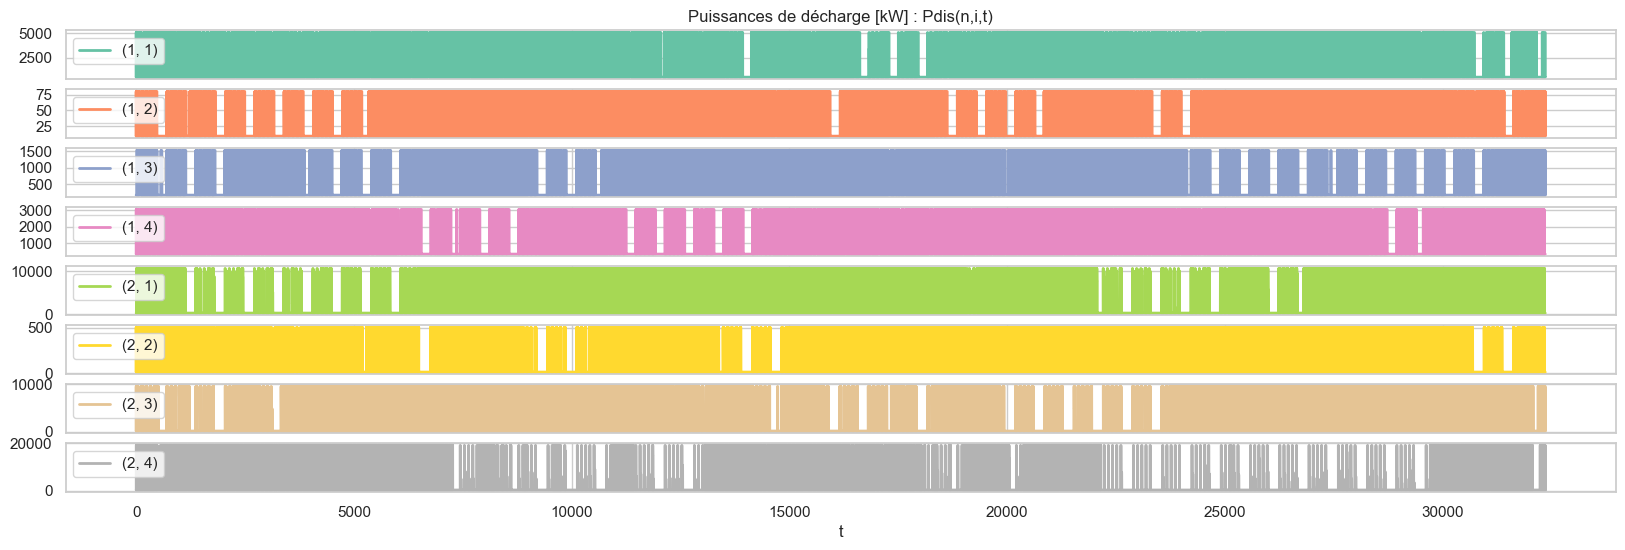

In [709]:
df_var = mdl.var_dict_as_df(solution=solus, var_dict=mdl.Pdis__n_i_t, index='t', columns=['n', 'i'])
g = df_var.plot(figsize=figure_size,subplots=True, drawstyle="steps", linewidth=2)
g[0].set_title('Puissances de décharge [kW] : Pdis(n,i,t)')
for i in g:
    i.legend(loc='upper left')
print(df_var.max())

n  i
1  1     5040.0
   2       80.0
   3     1520.0
   4     3040.0
2  1    10584.0
   2      504.0
   3     9576.0
   4    19152.0
dtype: float64


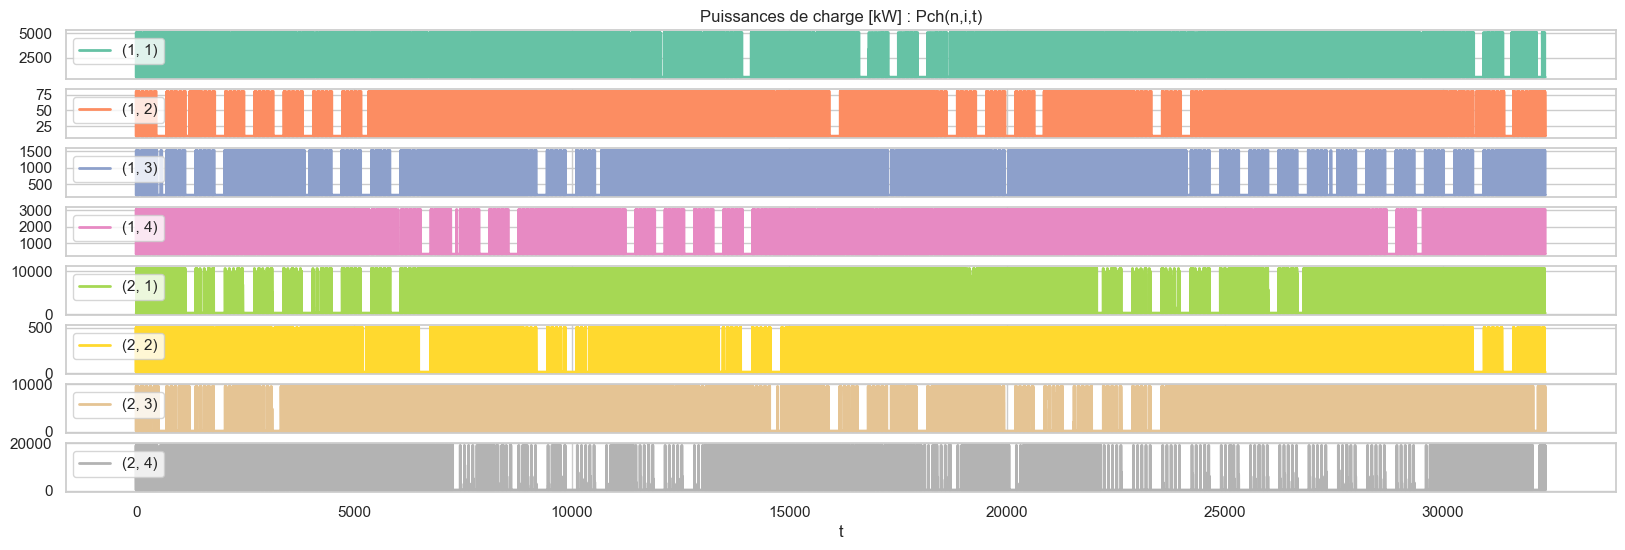

In [710]:
df_var = mdl.var_dict_as_df(solution=solus, var_dict=mdl.Pch__n_i_t, index='t', columns=['n', 'i'])
g = df_var.plot(figsize=figure_size,subplots=True, drawstyle="steps", linewidth=2)
g[0].set_title('Puissances de charge [kW] : Pch(n,i,t)')
for i in g:
    i.legend(loc='upper left')
print(df_var.max())

In [711]:
df_Pch__i_t = mdl.var_dict_as_df(solution=solus, var_dict=mdl.Pch_demand_i_t,
                                 index='t', columns='i', prefix='Pch__i_t__')
df_Pdis__i_t = mdl.var_dict_as_df(solution=solus, var_dict=mdl.Pch_demand_i_t,
                                 index='t', columns='i', prefix='Pdis__i_t__')
df_SOC__n_i_t = mdl.var_dict_as_df(solution=solus, var_dict=mdl.SOC__n_i_t, index='t', columns=['n', 'i'])
#print(df_Pch__i_t)
#print(df_Pdis__i_t)
#df_SOC__n_i_t.rename(mapper=lambda x: f'N_{x}', axis='columns', level=0, inplace=True)
#df_SOC__n_i_t.rename(mapper=lambda x: f'I_{x}', axis='columns', level=1, inplace=True)
#print(df_SOC__n_i_t)

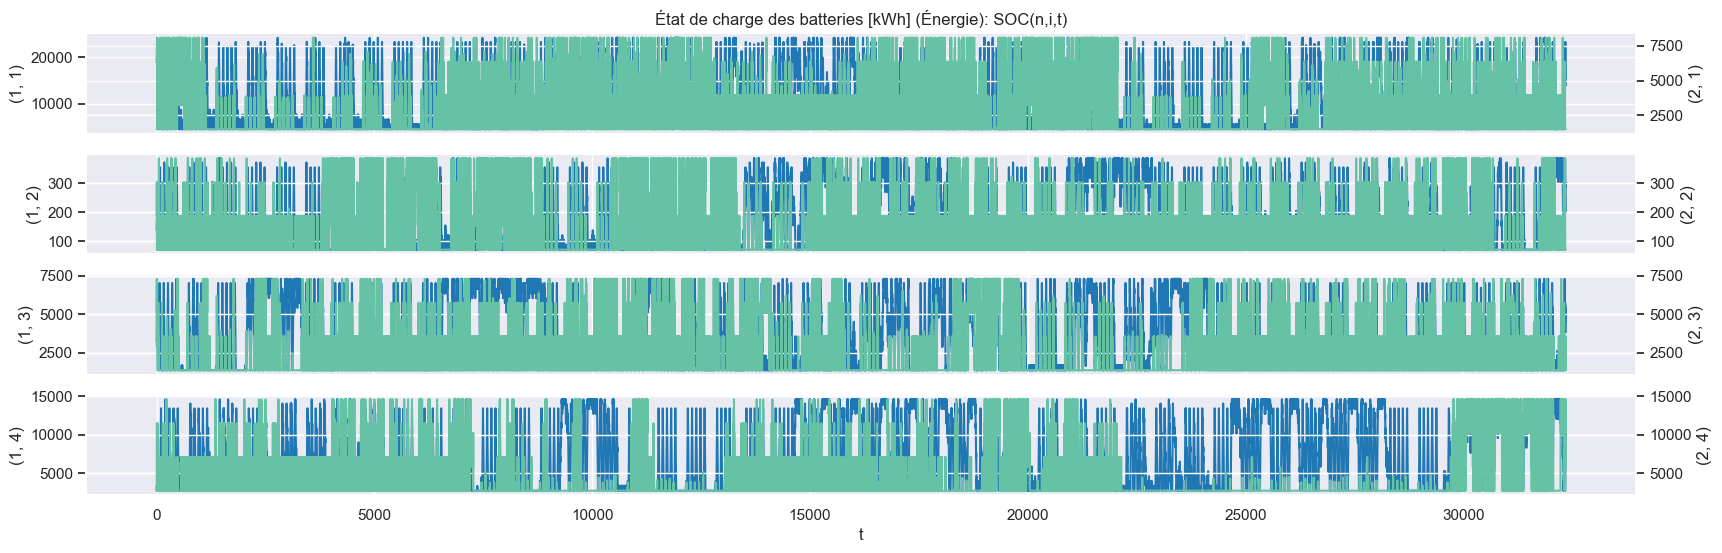

In [712]:
# Error Bands + valeur maximale des mois
title = "État de charge des batteries [kWh] (Énergie): SOC(n,i,t)"
what= 't'
#sns.set_theme(style="ticks")
sns.set_theme(style="darkgrid",palette='Set2')

fig, axs = plt.subplots(nrows=4, figsize=figure_size, sharex=True)
g = sns.lineplot(x=what, y=(1,1), estimator='max', data=df_SOC__n_i_t,  ax=axs[0],color='tab:blue')
ax2 = g.twinx()
h = sns.lineplot(x=what, y=(2,1), estimator='max', data=df_SOC__n_i_t, ax=ax2)
g = sns.lineplot(x=what, y=(1,2), estimator='max', data=df_SOC__n_i_t, ax=axs[1],color='tab:blue')
ax2 = g.twinx()
h = sns.lineplot(x=what, y=(2,2), estimator='max', data=df_SOC__n_i_t, ax=ax2)
g = sns.lineplot(x=what, y=(1,3), estimator='max', data=df_SOC__n_i_t, ax=axs[2],color='tab:blue')
ax2 = g.twinx()
h = sns.lineplot(x=what, y=(2,3), estimator='max', data=df_SOC__n_i_t, ax=ax2)
g = sns.lineplot(x=what, y=(1,4), estimator='max', data=df_SOC__n_i_t, ax=axs[3],color='tab:blue')
ax2 = g.twinx()
h = sns.lineplot(x=what, y=(2,4), estimator='max', data=df_SOC__n_i_t, ax=ax2)

for char in invalid:
	filename = title.replace(char, '_')+'.png'
filename = Path(save_dir,filename)

axs[0].title.set_text(title)
plt.show()
fig.savefig(filename, format='png', dpi=200, bbox_inches='tight')


month,1,2,3,4,5,6,7,8,9,10,11,12
year,,,,,,,,,,,,
2015,83.75,170.75,11.75,0.00,16.75,37.75,149.75,29.0,148.0,0.00,13.25,4.25
2016,214.25,236.00,76.00,6.75,33.75,67.00,158.75,82.0,89.0,8.25,6.75,75.00


month,1,2,3,4,5,6,7,8,9,10,11,12
year,,,,,,,,,,,,
2015,12.593985,25.676692,1.766917,0.000000,2.518797,5.676692,22.518797,4.360902,22.255639,0.000000,1.992481,0.639098
2016,20.336972,22.401519,7.214048,0.640721,3.203607,6.359753,15.068818,7.783579,8.448030,0.783104,0.640721,7.119127


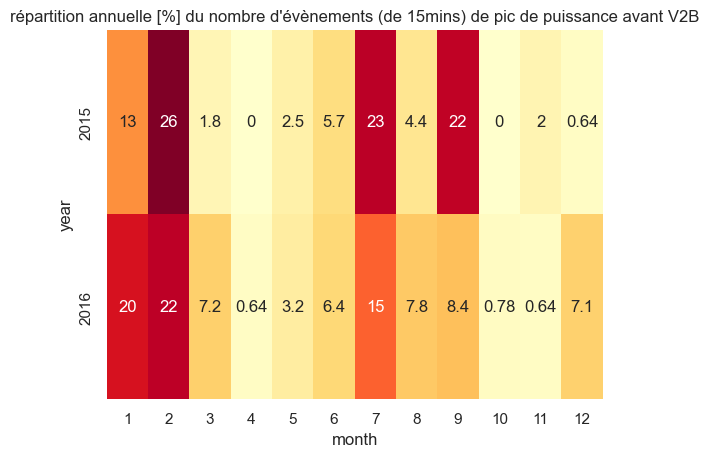

In [722]:

title = "répartition annuelle [%] du nombre d'évènements (de 15mins) de pic de puissance avant V2B"

rows = pd.crosstab(df.year, df.month, aggfunc='sum', values=df.is_peak, normalize=False)
rows = (15/60)*rows
display(rows)
rep_heure_avant= rows.copy()

rows = pd.crosstab(df.year, df.month, aggfunc='sum', values=df.is_peak, normalize="index")
rows = 100*rows
display(rows)
rep_perc_avant = rows.copy()
g = sns.heatmap(rows,cmap="YlOrRd", annot=True, cbar=False)

plt.title(title)

plt.show()
fig = g.get_figure()
for char in invalid:
	filename = title.replace(char, '_')+'.png'
filename = Path(save_dir,filename)
fig.savefig(filename, format='png', dpi=200, bbox_inches='tight')




(32352, 5)
                     year  week  weekday  is_workday
index                                               
2015-01-12 00:14:00  2015     3        1           1
2015-01-12 00:29:00  2015     3        1           1
2015-01-12 00:44:00  2015     3        1           1
2015-01-12 00:59:00  2015     3        1           1
2015-01-12 01:14:00  2015     3        1           1


month,1,2,3,4,5,6,7,8,9,10,11,12
year,,,,,,,,,,,,
2015,1.941748,38.834951,0.0,0.0,0.0,0.0,40.776699,0.0,18.446602,0.0,0.0,0.0


month,1,2,3,4,5,6,7,8,9,10,11,12
year,,,,,,,,,,,,
2015,0.5,10.0,0.0,0.0,0.0,0.0,10.5,0.0,4.75,0.0,0.0,0.0


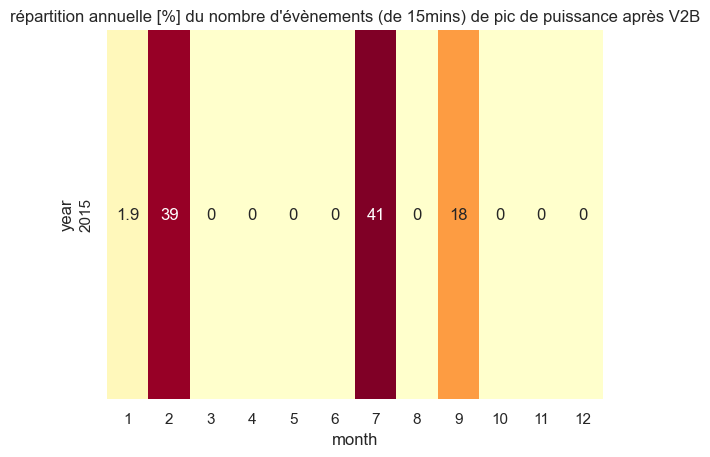

In [723]:
# Pourcentage of Peak per month (over the year)
# Debut d'hiver (chauffage) et Ete(climatisation) == dépense
peak_label = 'is_peak'
timestamp = 'Timestamp'
res = dk.copy(True)
print(res.shape)
res[timestamp] = res.index
res[peak_label] = np.where(res['Pr reseau']>=1, 1,0)

df_time = datetime_attributes(res,column=timestamp)
df_iso = datetime_isocalendar(res,column=timestamp)
dfk = pd.concat([res, df_time, df_iso[['week','weekday','is_workday']]],axis=1)
dfk['year_month'] = year_month_date_to_string(dfk.index)
dfk['month_week'] = 100*dfk['month']+dfk['week']

title = "répartition annuelle [%] du nombre d'évènements (de 15mins) de pic de puissance après V2B"

rows = pd.crosstab(dfk.year, dfk.month, aggfunc='sum', values=dfk.is_peak, normalize="index")
rows = 100*rows
display(rows)
rep_perc_apres = rows.copy()
g = sns.heatmap(rows,cmap="YlOrRd", annot=True, cbar=False)

rows = pd.crosstab(dfk.year, dfk.month, aggfunc='sum', values=dfk.is_peak, normalize=False)
rows = (15/60)*rows
display(rows)
rep_heure_apres = rows.copy()

plt.title(title)

plt.show()
fig = g.get_figure()
for char in invalid:
	filename = title.replace(char, '_')+'.png'
filename = Path(save_dir,filename)
fig.savefig(filename, format='png', dpi=200, bbox_inches='tight')

In [723]:
# add a table to the end and create a reference variable
# extra row is so we can add the header row
t = doc.add_table(t_df.shape[0]+1, t_df.shape[1])
#t.style = 'LightShading-Accent1'
# add the header rows.
for j in range(t_df.shape[-1]):
    t.cell(0,j).text = str(t_df.columns[j])
# add the rest of the data frame
for i in range(t_df.shape[0]):
    print(i)
    r = t_df.index[i]
    for j in range(t_df.shape[-1]):
        t.cell(i+1,j).text = str(t_df.values[i,j])


In [734]:
from docx import Document


def doc_table(doc, tab):
    # add a table to the end and create a reference variable
    # extra row is so we can add the header row
    t = doc.add_table(tab.shape[0]+1, tab.shape[1]+1)
    #t.style = 'LightShading-Accent1'
    # add the header rows.
    t.cell(0,0).text = 'index'
    for j in range(tab.shape[-1]):
        t.cell(0,j+1).text = str(tab.columns[j])
    # add the rest of the data frame
    for i in range(tab.shape[0]):
        print(i)
        r = tab.index[i]
        t.cell(i+1,0).text = str(r)
        for j in range(tab.shape[-1]):
            t.cell(i+1,j+1).text = str(tab.values[i,j])

doc = Document()
doc.add_heading('Résumé des informations du problème', 0)

doc.add_paragraph('Rborne[n,i]')
t_df = pd.DataFrame(mdl.Rborne__n_i)
doc_table(doc=doc, tab=t_df)

doc.add_paragraph('répartition annuelle avant V2B ')
t_rows = rep_perc_avant.round(decimals=1)
doc_table(doc=doc, tab=t_rows)

doc.add_paragraph('répartition annuelle après V2B ')
t_rows = rep_perc_apres.round(decimals=1)
doc_table(doc=doc, tab=t_rows)

doc.add_paragraph('répartition annuelle des temps de pics avant V2B [h]')
t_rows = rep_heure_avant.round(decimals=0).astype(int)
doc_table(doc=doc, tab=t_rows)

doc.add_paragraph('répartition annuelle des temps de pics après V2B [h]')
t_rows = rep_heure_apres.round(decimals=0).astype(int)
doc_table(doc=doc, tab=t_rows)



# save the doc
doc.save(Path(save_dir, 'tables.docx'))

0
1
0
1
0
0
1
0


## END OF MAIN

## TROUBLESHOOTING

i
1    1.0
2    1.0
3    1.0
4    1.0
dtype: float64
i
1    0
2    0
3    0
4    0
dtype: int64


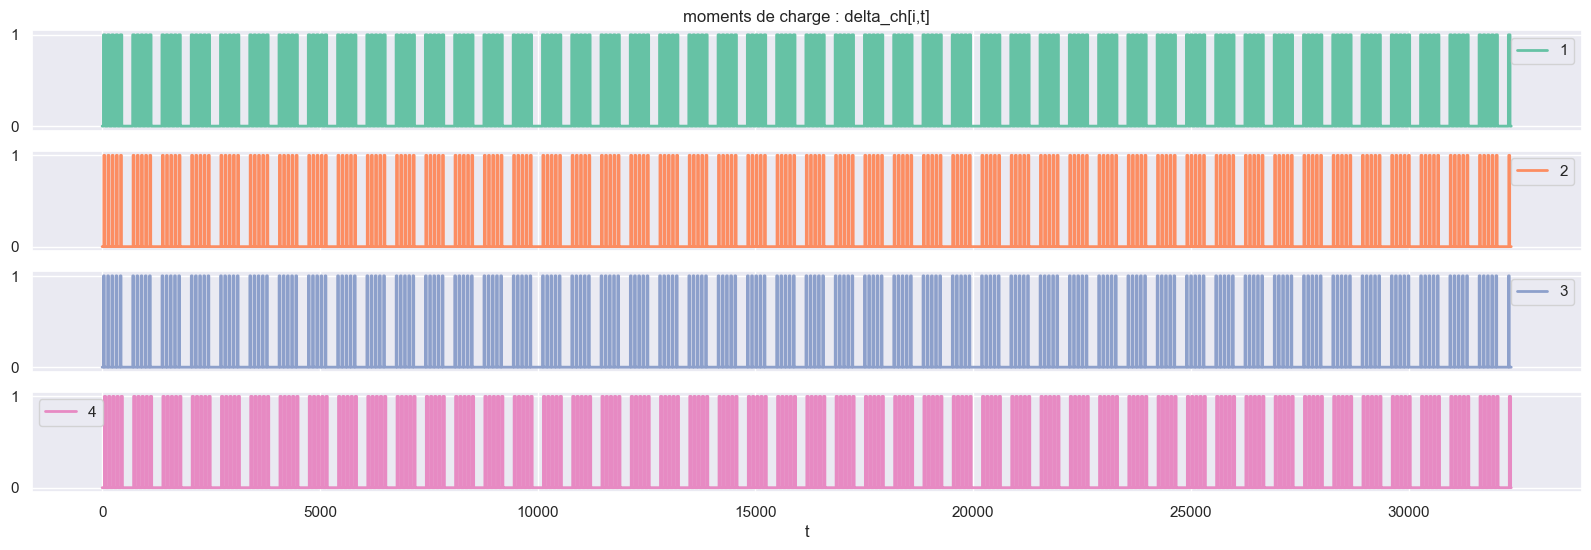

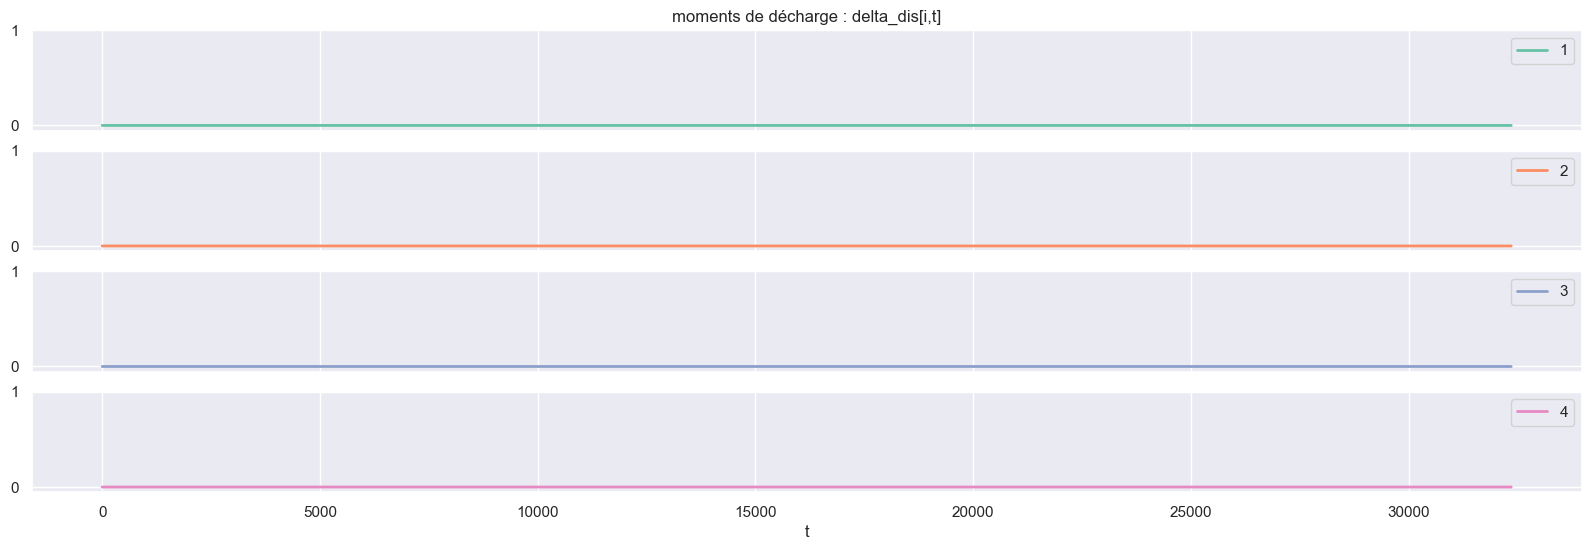

In [716]:
df_var = mdl.var_dict_as_df(solution=solus, var_dict=mdl.delta_ch__i_t, index='t', columns=['i'])
g = df_var.plot(figsize=figure_size,subplots=True, drawstyle="steps", linewidth=2)
g[0].set_title('moments de charge : delta_ch[i,t]')
print(df_var.max())
for a in g:
    a.set_yticks([0, 1])
df_var = mdl.var_dict_as_df(solution=solus, var_dict=mdl.delta_dis__i_t, index='t', columns=['i'])
g = df_var.plot(figsize=figure_size,subplots=True, drawstyle="steps", linewidth=2)
g[0].set_title('moments de décharge : delta_dis[i,t]')
for a in g:
    a.set_yticks([0, 1])
print(df_var.max())


In [717]:
#df_Rborne__n_i = mdl.var_dict_as_df(solution=solus, var_dict=mdl.Rborne__n_i,
#                                 index='i', columns='n')
#print(df_Rborne__n_i)